In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import pandas as pd
import os
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing as mp
from IPython.core.debugger import set_trace
from IPython.display import clear_output

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
import copy

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from umap import UMAP

import torch
from torch import nn
from torch import optim
from torch import autograd

from torch.utils.data import DataLoader

from train_utils import get_capacity, plot_weights_hist, train, get_grad_params
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         to_numpy, \
                         numpy_metric, \
                         cosine_sim

from input_utils import DataGenerator, make_random_affine
from models_utils import MLP_NonlinearEncoder, \
                         init_weights, \
                         universal_approximator, \
                         dJ_criterion, \
                         gained_function, \
                         adjust_learning_rate, \
                         compute_joint_probabilities, \
                         tsne_loss,\
                         tsne_criterion, \
                         sigmoid, \
                         initialize_nonlinearities

from embedding_utils import ConstructUMAPGraph, UMAPLoss, UMAPDataset, umap_criterion_compatibility

from pynndescent import NNDescent
from umap.umap_ import fuzzy_simplicial_set, make_epochs_per_sample
from sklearn.utils import check_random_state

import pygad
from torchga import TorchGA, model2vector, vector2model

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
N_CPU = mp.cpu_count()
SEED = 42
%autoreload 2

# Load data 

In [2]:
SCALER = StandardScaler()

input_parameters = {'generator': make_swiss_roll, #make_s_curve, 
                    'generator_kwargs': {'n_samples':10000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':True,
                    'scaler':SCALER,
                    'use_outpt_color':True} 

create_data = DataGenerator(**input_parameters)

inpt, _, color = create_data()

N_TEST = 1000

In [3]:
inpt.mean(1), inpt.std(1)

(array([-2.98427949e-17,  1.88116189e-16, -1.63424829e-17]),
 array([1., 1., 1.]))

In [4]:
inpt.max(1), inpt.min(1), inpt@inpt.T / inpt.shape[1]

(array([1.60772378, 1.74640626, 1.9881272 ]),
 array([-1.72833675, -1.71170231, -1.61472201]),
 array([[ 1.        ,  0.00978307,  0.10300087],
        [ 0.00978307,  1.        , -0.00312192],
        [ 0.10300087, -0.00312192,  1.        ]]))

In [5]:
inpt_train, inpt_test, color_train, color_test = train_test_split(inpt.T, 
                                                                  color, 
                                                                  random_state=42,
                                                                  test_size=N_TEST)

In [6]:
inpt_train_torch = torch.tensor(inpt_train, dtype=torch.float32).to(device)
inpt_test_torch = torch.tensor(inpt_test, dtype=torch.float32).to(device)

In [7]:
(inpt_train_torch.T@inpt_train_torch / inpt_train_torch.shape[0]).round()

tensor([[1., 0., 0.],
        [0., 1., -0.],
        [0., -0., 1.]], device='cuda:0')

In [8]:
inpt_train_torch.mean(0), inpt_train_torch.std(0)

(tensor([ 0.0006, -0.0022,  0.0009], device='cuda:0'),
 tensor([1.0013, 0.9994, 0.9986], device='cuda:0'))

In [9]:
inpt_train_torch.shape, inpt_test_torch.shape

(torch.Size([9000, 3]), torch.Size([1000, 3]))

In [10]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(inpt.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

# PCA

In [11]:
N_CYCLES = 1
data = [create_data()  for _ in range(N_CYCLES)]
inpt_data = np.concatenate([d[0] for d in data],-1)
outpt_data = np.concatenate([d[1] for d in data],-1)

3


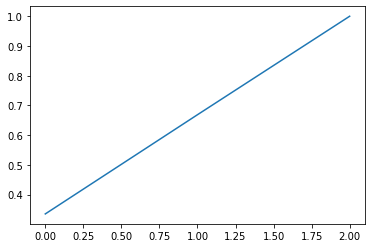

In [12]:
pca = PCA()
Z_pca = pca.fit_transform(inpt_data.T)
pca_ev = np.cumsum(pca.explained_variance_ratio_)
print((np.arange(1,inpt_data.shape[0]+1)[pca_ev > 0.99])[0])
plt.plot(pca_ev)
plt.show()

In [13]:
# plt.scatter(Z_pca[:,0], Z_pca[:,1], c=outpt_data[0])
# plt.colorbar()

In [86]:
# Z_pca_test = pca.transform(inpt_test.T)
# plt.scatter(Z_pca_test[:,0], Z_pca_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [87]:
# umap = UMAP(n_components=2, n_neighbors=50, n_jobs=1)
# Z = umap.fit_transform(inpt_data.T)
# Z_test = umap.transform(inpt_test.T)

In [88]:
# plt.scatter(Z[:,0], Z[:,1], c=outpt_data[0])
# plt.colorbar()

In [89]:
# plt.scatter(Z_test[:,0], Z_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [90]:
# Q_loc_val_UMAP, Q_glob_val_UMAP = calculate_Q_metrics(inpt_test.T, Z_test)

In [91]:
# Q_loc_val_UMAP, Q_glob_val_UMAP

In [261]:
# X,y = inpt_data.T, outpt_data[0]
# # X,y = Z, outpt_data[0]

# est = Ridge(alpha=0, fit_intercept=False)
# cross_val_score(est, X, y, scoring=make_scorer(r2_score))

In [262]:
# est.fit(X, y)
# r2_score(y, est.predict(X))

In [270]:
# output_sort = np.argsort(y)
# plt.plot(y[output_sort])
# plt.plot(est.predict(X)[output_sort], alpha=0.5)

In [113]:
# perplexities = [10,20,30,40]

# plt.figure(figsize=(20,5))
# for i,perplexity in enumerate(perplexities):
#     Z_tsne = TSNE(perplexity=perplexity).fit_transform(inpt.T)
#     ax = plt.subplot(1,len(perplexities),i+1)
#     ax.scatter(Z_tsne[:,0], Z_tsne[:,1], c=outp[0])
#     ax.set_title(f'{perplexity}')
# plt.tight_layout()
# plt.show()

# Train MLP

In [13]:
# J_s = [get_k_th_moment(4)]
# dJ_function = dJ_criterion(J_s)

In [142]:
LEARNING_TYPE = 'BP' #'Criterion', 'BP'

encoder_parameters = {
                    'input_dim':inpt.shape[0],
                    'hidden_dim':10,
                    'embedding_dim':2,
                    'add_readout':False,
                    'parametrized_f':True,
                    'W_requires_grad':True,
                    'final_nonlinearity':False,
                    'nonlinearity': universal_approximator,
                    'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
#                     'nonlinearity': gained_function,
#                     'f_kwargs':{'function':torch.tanh},
                    'layers_number':2,
                    'add_bn':False,
                    'seed':None,
                    'set_seed':False,
                     }


network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

Net capacity: 260
Parameters:
W_s.0 torch.Size([10, 3]) requires_grad: True
W_s.1 torch.Size([2, 10]) requires_grad: True
f_s.0.theta1 torch.Size([10, 10]) requires_grad: True
f_s.0.bias1 torch.Size([10, 10]) requires_grad: True
f_s.0.theta2 torch.Size([1, 10]) requires_grad: True


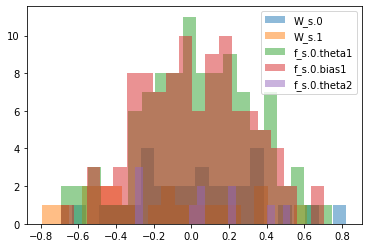

In [144]:
print('Net capacity:', get_capacity(network))
print('Parameters:')

for name, param in network.named_parameters():
    print(name, param.shape, 'requires_grad:', param.requires_grad)
#     plt.figure()
    W = to_numpy(param.data)
    plt.hist(W.flatten(),bins=20, alpha=0.5, label=f'{name}')
#     W /= np.linalg.norm(W, axis=1, keepdims=True)
#     print(W@W.T)
plt.legend()
plt.show()

In [145]:
X_s = network.forward(inpt_test_torch)
outpt_val_pred = to_numpy(X_s[-1])
outpt_val_pred.shape

(2, 1000)

In [146]:
for W in network.W_s:
    print(W.shape)

torch.Size([10, 3])
torch.Size([2, 10])


In [147]:
# network.hebbian_learning_step(X_s, # list of layer activations [L,T,d_k]
#                               None, # readout
#                               learning_type='Criterion',
#                               learning_rate=1e-1,
#                               weight_decay=0)

In [148]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(outpt_val_pred.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()


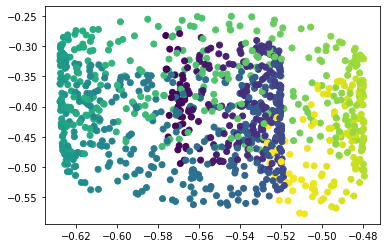

In [149]:
plt.scatter(outpt_val_pred[0], outpt_val_pred[1], c=color_test)
plt.show()

### Setting criterion params

In [150]:
graph_constructor = ConstructUMAPGraph(metric='euclidean', 
                                        n_neighbors=15, 
                                        random_state=SEED)

# (epochs_per_sample, head, tail, weight) 
train_graph_data = graph_constructor(inpt_train)
test_graph_data = graph_constructor(inpt_test)

BATCH_SIZE_BP = 10000

dataset_train = UMAPDataset(inpt_train, *train_graph_data, device=device, batch_size=BATCH_SIZE_BP)
dataset_test = UMAPDataset(inpt_test, *test_graph_data, device=device, batch_size=BATCH_SIZE_BP)

criterion_umap = UMAPLoss(device=device, 
                         min_dist=0.1,
                         negative_sample_rate=5,
                         edge_weight=None,
                         repulsion_strength=1.0)

criterion = umap_criterion_compatibility(criterion_umap)

Sat Jul  9 18:13:39 2022 Building RP forest with 10 trees
Sat Jul  9 18:13:39 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Sat Jul  9 18:13:39 2022 Building RP forest with 7 trees
Sat Jul  9 18:13:39 2022 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	Stopping threshold met -- exiting after 2 iterations


In [154]:
len(dataset_train), len(dataset_test)

(102, 11)

In [155]:
# X_s = network(input_batch)
# criterion(X_s)

In [156]:
# network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

# STOPPING_CRITERION = lambda y_pred, y_true: 1 - get_pred_index(r2_score_torch, -1)(y_pred, y_true)
# VAL_METRICS_REGRESSION = {'r2_score': get_pred_index(r2_score_torch, -1)}
# CRITERION = lambda y_pred, y: -get_k_th_moment(4)(y_pred)
# CRITERION = strain

criterion_kwargs = defaultdict(dict)

CRITERION = criterion

criterion_kwargs['skip_train'] = False
criterion_kwargs['skip_val'] = False

# criterion_kwargs['val'] = {'P':P_test_torch, 'perplexity':PERPLEXITY}
# criterion_kwargs['train'] = {'perplexity':PERPLEXITY}

training_parameters = edict({'learning_type':LEARNING_TYPE,\
                               'lr':1e-3, # learning-rate 
                               'lr_theta':1e-3,
                               'enable_grad_train':True,
                               'enable_grad_val':False,
                               'maxiter':1000, # maxiter
                               'tol':1e-2, # loss tolerance for early stopping 
                               'wd':0, # weight-decay
                               'shuffle':True, # shuffle data
                               'progress_bar':True,
                               'weight_saver':None,
                               'calculate_grad':False,
                               'clip_grad_value': None,
                               'val_metrics':None,
                               'device':device
                             })

opt = None
if training_parameters['learning_type'] == 'BP': 
    opt = optim.Adam(get_grad_params(network.parameters()), 
                     lr=training_parameters.lr_theta,  
                     weight_decay=training_parameters.wd)



In [157]:
if opt is not None:
    print(len(opt.param_groups[0]['params']))

5


In [159]:
metric_dict = None
training_parameters['learning_type'] = LEARNING_TYPE
training_parameters['epochs'] = 500

network, opt, metric_dict = train(network, 
                                  opt=opt, 
                                  criterion=CRITERION,
                                  criterion_kwargs=criterion_kwargs,
                                  parameters=training_parameters,
                                  train_dataloader=dataset_train,
                                  val_dataloader=dataset_test, 
                                  metric_dict=metric_dict,
                                  val_metrics=None
                                 )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.01it/s]


In [160]:
# training_parameters['learning_type'] = "BP"
# training_parameters['batch_size'] = T
# training_parameters['epochs'] = 5000


# GRAD_PARAMS = list(filter(lambda x: x.requires_grad, network.parameters()))

# opt = optim.Adam(GRAD_PARAMS, 
#                  lr=training_parameters.lr_theta, 
#                  weight_decay=training_parameters.wd)

# network, opt, metric_dict = train(network, 
#                                   opt=opt, 
#                                   criterion=l2_loss,
#                                   train_params=training_parameters,
#                                   data_params=input_parameters, 
#                                   val_data={'inpt':inpt_torch_test,'outpt':outpt_torch_test},
#                                   metric_dict=metric_dict 
#                                   )

In [209]:
# state_dict = torch.load('./results/mlp_nonlinear/checkpoints/MLP_BP_hdim-10_lnum-2_Wgrad-1_fgrad-1_universal_approximator')
# network.load_state_dict(state_dict)

In [217]:
# X_s_pred = [to_numpy(X) for X in network(inpt_test_torch.to('cpu'))]
# outpt_val_pred = X_s_pred[-1]


In [218]:

# plt.figure(figsize=(20,5))

# ax1 = plt.subplot(1,4,1)
# ax1.plot(metric_dict['criterion_train'])
# ax1.set_title('criterion_train')

# ax2 = plt.subplot(1,4,2)
# ax2.plot(metric_dict['criterion_val'])
# ax2.set_title('criterion_val')

# plt.tight_layout()
# plt.show()

In [219]:
Q_loc_val_NET, Q_glob_val_NET = calculate_Q_metrics(inpt_test, outpt_val_pred.T)

In [220]:
Q_loc_val_NET, Q_glob_val_NET

(0.7527679469481328, 0.6972272138137002)

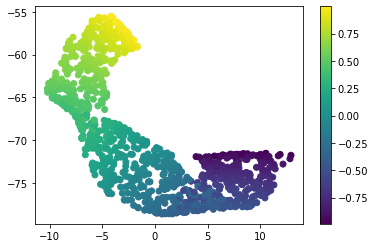

In [216]:
plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test)
plt.colorbar()
plt.show()

In [165]:
X = X_s_pred[1]

In [167]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(X.T, columns=['x','y', 'z'])
# df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

#### 3 layers, hidden dim  10
 - $f_{theta}$ only. $Q_l$ 0.52, $Q_g$: 0.75, loss ~ 0.15, still curved and overlapping embedding
 - $f_{theta}$ and $W$. $Q_l$ 0.78, $Q_g$: 0.7, loss ~ 0.07 - nicely flatten 

In [168]:
root_checkpoints = 'results/mlp_nonlinear/checkpoints'
hdim = encoder_parameters['hidden_dim']
lnum = encoder_parameters['layers_number']
Wgrad = int(encoder_parameters['W_requires_grad'])
fgrad = int(encoder_parameters['parametrized_f'])
fname = encoder_parameters['nonlinearity'].__name__

experiment_name = 'MLP_' + LEARNING_TYPE + f'_hdim-{hdim}' + \
                  f'_lnum-{lnum}' + f'_Wgrad-{Wgrad}' + f'_fgrad-{fgrad}' + f'_{fname}' 

checkpoint_name = os.path.join(root_checkpoints, experiment_name)
torch.save(network.state_dict(), checkpoint_name)

In [169]:
# n_fs = len(network.f_s)
# ξ = torch.linspace(-5,5,1000).to(device)

# for layer in range(n_fs):
#     f_theta = network.f_s[layer]
#     if network.final_nonlinearity or layer < n_fs-1:
#         n_neurons = f_theta.input_dim
#         y = torch.stack([ξ for _ in range(n_neurons)],0) # [n_neurons, T]

#         f = to_numpy(f_theta(y)) # [n_neurons, T]

#         fig, axes = plt.subplots(ncols=n_neurons, nrows=1, figsize=(n_neurons*3,3))

#         for j,ax in enumerate(axes):
#             ax.plot(to_numpy(ξ), f[j])
#             ax.set_title(f'Neuron: {j}')

#         fig.suptitle(f'Layer: {layer}', y=1.1, color='blue')
    
# plt.tight_layout()
# plt.show()

In [29]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(outpt_val_pred.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

In [28]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(np.concatenate([inpt_test, outpt_val_pred], axis=1).T, columns=['x','y', 'z'])

# df['target'] = np.concatenate([np.zeros((inpt.shape[1])), 
#                                np.ones((inpt_test.shape[1]))])

# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')

# fig.show()